In [75]:
import pandas as pd
import plotly.express as px

columns = [
        'join_id','dt','chain', 'active_secs_per_day'
        ,'num_l1_txs_inbox','num_l1_txs_output','calldata_bytes_l1_inbox'
        ,'avg_l1_gas_price_on_l1_inbox','avg_l1_gas_price_on_l1_output','avg_l1_gas_price_on_l2'
        ,'l1_gas_used_inbox','l1_gas_used_output','l1_gas_used_combined'
        ,'l1_eth_fees_inbox','l1_eth_fees_output','l1_eth_fees_combined'
        ,'l1_contrib_l2_eth_fees_per_day','l2_contrib_l2_eth_fees_per_day'
        ,'l2_num_txs_per_day', 'l2_num_attr_deposit_txs_per_day', 'l2_num_user_deposit_txs_per_day'
        ,'l1_gas_used_on_l2','calldata_bytes_l2_per_day'
        ,'l1_gas_used_user_txs_l2_per_day','calldata_bytes_user_txs_l2_per_day'
        ,'l2_gas_used','l2_eth_fees_per_day'
        ]

In [76]:
#Unify datasets
dunedf = pd.read_csv('csv_inputs/op_chain_gas_economics_dune_query_2453515_dt2023_09_08.csv') #https://dune.com/queries/2453515 --last 90 days
goldskydf = pd.read_csv('csv_inputs/op_chain_gas_economics_goldsky_zora_pgn_dt2023_09_08.csv') #requires auth - https://dash.goldsky.com/question/9-op-chains-activity-by-period

In [77]:
# Map Chain Names
chain_mappings = {
    'zora': 'Zora Network',
    'pgn': 'Public Goods Network',
    # Add more mappings as needed
}
goldskydf['chain'] = goldskydf['chain'].replace(chain_mappings)

In [78]:
#Configure
#rename cols
dunedf = dunedf.rename(columns={
                        'name':'chain'
                        })
#Generate Join ID Column
dunedf['join_id'] = dunedf['dt'].astype(str).str[:10].str.cat(dunedf['chain'].astype(str).str.lower())
goldskydf['join_id'] = goldskydf['dt'].astype(str).str[:10].str.cat(goldskydf['chain'].astype(str).str.lower())

# display(dunedf.head(10))
# print(dunedf.columns)
# print('---')
# display(goldskydf.head(10))
# print(goldskydf.columns)

combo_df = dunedf.merge(goldskydf, on='join_id', how='left')

# display(combo_df)

for c in columns:
        try:
                combo_df[c] = combo_df[c+'_x'].combine_first(combo_df[c+'_y']) #pick first non-null
        except:
                combo_df[c] = combo_df[c] #nada

combo_df['dt'] = pd.to_datetime(combo_df['dt'])
combo_df = combo_df[columns]

combo_df['gas_compression_ratio'] = combo_df['l1_gas_used_inbox'] / combo_df['l1_gas_used_on_l2']
combo_df['bytes_compression_ratio'] = combo_df['calldata_bytes_l1_inbox'] / combo_df['calldata_bytes_l2_per_day']
combo_df['dt_rank'] = combo_df['dt'].rank(method='dense', ascending=False).astype('int')

In [79]:
display( combo_df.sample(5) )

combo_df.to_csv('outputs/op_chain_gas_economics_sample.csv')

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l1_gas_used_user_txs_l2_per_day,calldata_bytes_user_txs_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
152,2023-07-31op mainnet,2023-07-31 00:00:00+00:00,OP Mainnet,86400.0,1214,24,138059313.0,24.227825,23.986172,2.399308e+01,...,982.0,3.719761e+09,325680547.0,3.719761e+09,314075371.0,1.729702e+11,75.747456,0.598965,0.423910,39
5,2023-09-06base,2023-09-06 00:00:00+00:00,Base,86400.0,1424,24,57450098.0,19.107476,17.935865,1.899765e+01,...,577.0,1.453732e+09,113272698.0,1.453732e+09,101784370.0,2.212035e+11,32.901866,0.650960,0.507184,2
182,2023-07-24zora network,2023-07-24 00:00:00+00:00,Zora Network,86400.0,146,24,3936175.0,29.897816,31.260980,4.644531e+09,...,1.0,5.462253e+07,17573964.0,5.462253e+07,4358055.0,4.804534e+10,2.506763,1.206196,0.223978,46
205,2023-07-18zora network,2023-07-18 00:00:00+00:00,Zora Network,86400.0,163,24,6454904.0,28.801545,29.207270,4.676844e+09,...,4.0,9.364356e+07,18423326.0,9.364356e+07,7189646.0,5.146252e+10,4.240936,1.135517,0.350366,52
134,2023-08-05zora network,2023-08-05 00:00:00+00:00,Zora Network,86400.0,146,24,5685430.0,15.814547,15.885622,5.562570e+09,...,1.0,1.172829e+08,20236135.0,1.172829e+08,8992179.0,5.152439e+10,3.904547,0.799716,0.280954,34


In [80]:
bl_gas_ratio = combo_df['l1_gas_used_inbox'].sum() / combo_df['l1_gas_used_on_l2'].sum()
bl_bytes_ratio = combo_df['calldata_bytes_l1_inbox'].sum() / combo_df['calldata_bytes_l2_per_day'].sum()
print('Blended gas compression ratio: ' + str(round(bl_gas_ratio*100,1)) + '%')
print('Blended bytes compression ratio: ' + str(round(bl_bytes_ratio*100,1)) + '%')

Blended gas compression ratio: 63.0%
Blended bytes compression ratio: 44.0%


In [81]:
# Create the scatter plot
combo_df_plot = combo_df[
                        (~combo_df['gas_compression_ratio'].isna()) 
                         & (combo_df['gas_compression_ratio']<1) 
                         & (combo_df['active_secs_per_day'] == 86400)
                         ]

# combo_df_plot = combo_df[(~combo_df['bytes_compression_ratio'].isna())
#                          & (combo_df['active_secs_per_day'] == 86400)]

display(combo_df_plot)

fig = px.scatter(combo_df_plot,
                 x='l1_gas_used_user_txs_l2_per_day',#'l1_gas_used_on_l2',
                 y='l1_gas_used_inbox',
                 size = 'gas_compression_ratio',
                 color='chain',
                 title='L1 Gas Used on each Layer by chain')

# Display the plot
fig.show()

##############

fig_bytes = px.scatter(combo_df_plot,
                 x='calldata_bytes_user_txs_l2_per_day',#'calldata_bytes_l2_per_day',
                 y='calldata_bytes_l1_inbox',
                 size = 'bytes_compression_ratio',
                 color='chain',
                 title='Calldata Bytes on each Layer by chain')

fig_bytes.show()

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l1_gas_used_user_txs_l2_per_day,calldata_bytes_user_txs_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
0,2023-09-07op mainnet,2023-09-07 00:00:00+00:00,OP Mainnet,86400.0,614,24,70967575.0,17.876005,17.564603,1.763472e+01,...,449.0,1.797814e+09,149355858.0,1.797814e+09,137925070.0,1.373005e+11,31.358216,0.636979,0.475158,1
1,2023-09-07base,2023-09-07 00:00:00+00:00,Base,86400.0,1431,24,56170604.0,18.223106,17.189830,1.809397e+01,...,760.0,1.417440e+09,110999142.0,1.417440e+09,99428281.0,2.211692e+11,32.802708,0.653330,0.506045,1
2,2023-09-07zora network,2023-09-07 00:00:00+00:00,Zora Network,86400.0,183,24,13738192.0,17.591169,18.234762,1.133676e+10,...,26.0,3.326724e+08,29555694.0,3.326724e+08,18305698.0,6.944849e+10,11.796937,0.670250,0.464824,1
4,2023-09-06op mainnet,2023-09-06 00:00:00+00:00,OP Mainnet,86400.0,616,24,71236352.0,19.110582,18.172530,1.885265e+01,...,361.0,1.827877e+09,152566694.0,1.827877e+09,141179234.0,1.455955e+11,33.899695,0.628893,0.466919,2
5,2023-09-06base,2023-09-06 00:00:00+00:00,Base,86400.0,1424,24,57450098.0,19.107476,17.935865,1.899765e+01,...,577.0,1.453732e+09,113272698.0,1.453732e+09,101784370.0,2.212035e+11,32.901866,0.650960,0.507184,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2023-06-14op mainnet,2023-06-14 00:00:00+00:00,OP Mainnet,86400.0,846,24,93347122.0,22.388467,20.089097,2.182302e+01,...,481.0,2.523803e+09,201883259.0,2.523803e+09,190445463.0,1.965987e+11,55.608184,0.597109,0.462382,86
316,2023-06-13op mainnet,2023-06-13 00:00:00+00:00,OP Mainnet,86400.0,783,24,85583465.0,17.184042,16.949245,1.703237e+01,...,430.0,2.251531e+09,187008884.0,2.251531e+09,175594140.0,1.736718e+11,33.476594,0.613762,0.457644,87
318,2023-06-12op mainnet,2023-06-12 00:00:00+00:00,OP Mainnet,86400.0,753,24,81822522.0,17.964138,17.094217,1.779595e+01,...,470.0,2.173674e+09,186071777.0,2.173674e+09,174641833.0,1.592237e+11,31.749409,0.607850,0.439736,88
319,2023-06-11op mainnet,2023-06-11 00:00:00+00:00,OP Mainnet,86400.0,698,24,75076007.0,17.448444,16.546322,1.713917e+01,...,446.0,2.022271e+09,176495625.0,2.022271e+09,165072977.0,1.470628e+11,29.800585,0.599574,0.425370,89


In [82]:
new_data = combo_df[combo_df['active_secs_per_day'] == 86400].copy()
display(new_data.sample(5))

,join_id,dt,chain,active_secs_per_day,num_l1_txs_inbox,num_l1_txs_output,calldata_bytes_l1_inbox,avg_l1_gas_price_on_l1_inbox,avg_l1_gas_price_on_l1_output,avg_l1_gas_price_on_l2,...,l2_num_user_deposit_txs_per_day,l1_gas_used_on_l2,calldata_bytes_l2_per_day,l1_gas_used_user_txs_l2_per_day,calldata_bytes_user_txs_l2_per_day,l2_gas_used,l2_eth_fees_per_day,gas_compression_ratio,bytes_compression_ratio,dt_rank
99,2023-08-14public goods network,2023-08-14 00:00:00+00:00,Public Goods Network,86400.0,145,24,1883177.0,20.969477,20.444432,4.462198e+07,...,52.0,6.966840e+05,11300801.0,6.966840e+05,46961.0,4.324323e+10,0.033370,47.543994,0.166641,25
180,2023-07-24op mainnet,2023-07-24 00:00:00+00:00,OP Mainnet,86400.0,1222,24,139368835.0,34.602483,30.747022,3.455188e+01,...,955.0,4.059129e+09,365674466.0,4.059129e+09,354051894.0,1.868562e+11,116.038609,0.554032,0.381128,46
120,2023-08-08op mainnet,2023-08-08 00:00:00+00:00,OP Mainnet,86400.0,1594,24,187088490.0,23.122305,24.298956,2.310464e+01,...,406.0,4.659603e+09,376881201.0,4.659603e+09,365475993.0,1.995162e+11,94.102721,0.647632,0.496412,31
264,2023-07-01base,2023-07-01 00:00:00+00:00,Base,86400.0,1428,24,2034658.0,17.041905,15.960229,NaN,...,0.0,NaN,11232000.0,0.000000e+00,0.0,2.169690e+09,0.000000,NaN,0.181148,69
165,2023-07-28base,2023-07-28 00:00:00+00:00,Base,86400.0,398,25,4142318.0,34.784639,39.341341,3.038785e+01,...,14.0,6.728456e+07,15577663.0,6.728456e+07,4339332.0,3.876736e+09,3.764855,1.106144,0.265914,42


In [83]:
selected_columns = [
    'l2_num_txs_per_day', 'l2_num_attr_deposit_txs_per_day', 
    'l2_num_user_deposit_txs_per_day', 'l1_gas_used_on_l2', 
    'calldata_bytes_l2_per_day', 'l1_gas_used_user_txs_l2_per_day', 
    'calldata_bytes_user_txs_l2_per_day', 'l1_gas_used_inbox'
]

missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                    0
l2_num_attr_deposit_txs_per_day       0
l2_num_user_deposit_txs_per_day       0
l1_gas_used_on_l2                     9
calldata_bytes_l2_per_day             0
l1_gas_used_user_txs_l2_per_day       0
calldata_bytes_user_txs_l2_per_day    0
l1_gas_used_inbox                     0
dtype: int64

In [84]:
# Filling the missing values in 'l1_gas_used_on_l2' with 0
new_data['l1_gas_used_on_l2'].fillna(0, inplace=True)
new_data['calldata_bytes_l2_per_day'].fillna(0, inplace=True)
new_data['l1_gas_used_user_txs_l2_per_day'].fillna(0, inplace=True)
new_data['calldata_bytes_user_txs_l2_per_day'].fillna(0, inplace=True)

# Verifying that there are no more missing values in the selected columns
missing_values_in_selected_columns = new_data[selected_columns].isnull().sum()
missing_values_in_selected_columns

l2_num_txs_per_day                    0
l2_num_attr_deposit_txs_per_day       0
l2_num_user_deposit_txs_per_day       0
l1_gas_used_on_l2                     0
calldata_bytes_l2_per_day             0
l1_gas_used_user_txs_l2_per_day       0
calldata_bytes_user_txs_l2_per_day    0
l1_gas_used_inbox                     0
dtype: int64

In [85]:
# Step 2: Feature Selection - Examining the correlation between the potential features and the target variable
correlation_matrix = new_data[selected_columns].corr()

# Getting the correlation of all features with the target variable 'l1_gas_used_inbox'
target_correlation = correlation_matrix['l1_gas_used_inbox']

# Displaying the correlation values
target_correlation

l2_num_txs_per_day                    0.963618
l2_num_attr_deposit_txs_per_day            NaN
l2_num_user_deposit_txs_per_day       0.430622
l1_gas_used_on_l2                     0.996341
calldata_bytes_l2_per_day             0.982320
l1_gas_used_user_txs_l2_per_day       0.996341
calldata_bytes_user_txs_l2_per_day    0.981972
l1_gas_used_inbox                     1.000000
Name: l1_gas_used_inbox, dtype: float64

In [86]:
# GPT Built model
from sklearn.model_selection import train_test_split

# Step 3: Data Splitting - Splitting the data into training and testing sets

# Selected features
features = [
    'l1_gas_used_user_txs_l2_per_day', 
    'calldata_bytes_user_txs_l2_per_day', 
    'l2_num_txs_per_day', 
    # 'l2_num_user_deposit_txs_per_day'
]

# Target variable
target = 'l1_gas_used_inbox'

# Splitting the data into training and testing sets (80% training, 20% testing)
X = new_data[features]
y = new_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((253, 3), (64, 3))

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 4: Model Training - Training a linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Step 5: Model Evaluation - Evaluating the model on the testing set
y_pred_linear = linear_regressor.predict(X_test)

# Calculate the model performance
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_linear, r2_linear

(6405319238870022.0, 0.9880430263573804)

In [88]:
# Extracting the coefficients and intercept from the trained model
intercept = linear_regressor.intercept_
coefficients = linear_regressor.coef_

# Creating a dictionary to hold the feature names and their respective coefficients
feature_coeff_dict = dict(zip(features, coefficients))

# Displaying the intercept and coefficients
intercept, feature_coeff_dict

(41006791.757902145,
 {'l1_gas_used_user_txs_l2_per_day': 1.2154891627327191,
  'calldata_bytes_user_txs_l2_per_day': -4.488535297054213,
  'l2_num_txs_per_day': -1373.5237197280999})

In [89]:
from joblib import dump

# Save the model to a file
model_filepath = 'outputs/linear_regression_l1_gas_used_inbox_model.joblib'
dump(linear_regressor, model_filepath)


['outputs/linear_regression_l1_gas_used_inbox_model.joblib']

In [90]:
# Create a string to represent the regression equation
equation_str = f"l1_gas_used_inbox = {intercept:.2f}"
for feature, coef in feature_coeff_dict.items():
    equation_str += f" + ({coef:.2f}) * {feature}"

# Print out the regression equation
print(equation_str)

l1_gas_used_inbox = 41006791.76 + (1.22) * l1_gas_used_user_txs_l2_per_day + (-4.49) * calldata_bytes_user_txs_l2_per_day + (-1373.52) * l2_num_txs_per_day


In [91]:
# Find inputs
# Convert the 'dt' column to datetime data type
new_data['dt'] = pd.to_datetime(new_data['dt'])

# Identify the most recent date in the dataset
most_recent_date = new_data['dt'].max()

# Identify the date that is 30 days before the most recent date
date_30_days_ago = most_recent_date - pd.Timedelta(days=30)

# Filter the data to include only the most recent 30 days
recent_30_days_data = new_data[new_data['dt'] > date_30_days_ago]

# Group the data by 'chain' and calculate the average values for each of the input features over the most recent 30 days
average_values_per_chain = recent_30_days_data.groupby('chain')[features].mean()

# Resetting the index to have 'chain' as a column
average_values_per_chain = average_values_per_chain.reset_index()

# Calculate the per transaction values for 'l1_gas_used_on_l2' and 'calldata_bytes_l2_per_day'
average_values_per_chain['l1_gas_used_user_txs_on_l2_per_tx'] = average_values_per_chain['l1_gas_used_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']
average_values_per_chain['calldata_bytes_user_txs_l2_per_tx'] = average_values_per_chain['calldata_bytes_user_txs_l2_per_day'] / average_values_per_chain['l2_num_txs_per_day']

# Create a new DataFrame to hold the 'per_tx' values
average_values_per_tx_chain = average_values_per_chain[['chain', 'l1_gas_used_user_txs_on_l2_per_tx', 'calldata_bytes_user_txs_l2_per_tx', 'l2_num_txs_per_day']]



# Display the average values per chain
display(average_values_per_tx_chain)

,chain,l1_gas_used_user_txs_on_l2_per_tx,calldata_bytes_user_txs_l2_per_tx,l2_num_txs_per_day
0,Base,3898.924763,243.251709,518027.300000
1,OP Mainnet,5555.096389,441.357025,420899.633333
2,Public Goods Network,9513.624478,1044.872894,678.700000
3,Zora Network,3300.680661,181.923644,76236.068966


/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_39914/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_39914/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_39914/3940818164.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

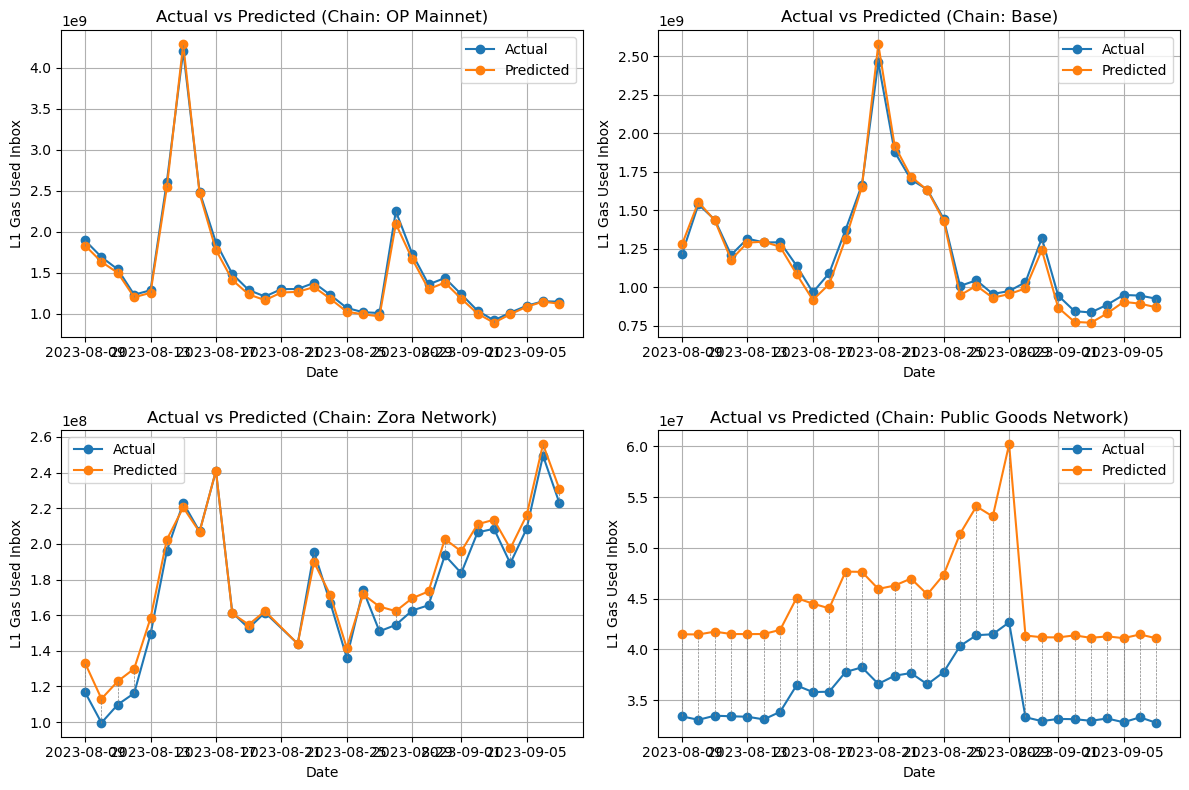

In [92]:
import matplotlib.pyplot as plt
# Setting up the plot
plt.figure(figsize=(12, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain
    chain_data = recent_30_days_data[recent_30_days_data['chain'] == chain]
    
    # Making predictions using the new model
    chain_data['predicted_l1_gas_used_inbox_new'] = linear_regressor.predict(chain_data[features])
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_new'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox_new'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain})')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


In [93]:
#Stratify sampling

from sklearn.model_selection import StratifiedShuffleSplit

# Resetting the index of new_data before performing stratified sampling
new_data.reset_index(drop=True, inplace=True)

# Defining the stratified shuffle split object to split the data into training and testing sets with stratification on the 'chain' column
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


# Splitting the data into training and testing sets using stratified sampling
for train_index, test_index in stratified_split.split(new_data, new_data['chain']):
    stratified_train_data = new_data.loc[train_index]
    stratified_test_data = new_data.loc[test_index]

# Training the linear regression model using the stratified training set
X_train_stratified = stratified_train_data[features]
y_train_stratified = stratified_train_data['l1_gas_used_inbox']
X_test_stratified = stratified_test_data[features]
y_test_stratified = stratified_test_data['l1_gas_used_inbox']

linear_regressor_stratified = LinearRegression()
linear_regressor_stratified.fit(X_train_stratified, y_train_stratified)

# Predicting the target variable on the stratified testing set
stratified_test_data['predicted_l1_gas_used_inbox'] = linear_regressor_stratified.predict(X_test_stratified)

# Setting up the plot for visualization of residuals for each chain
plt.figure(figsize=(12, 8))

# Looping over each chain to plot the actual vs. predicted values and residuals
for i, chain in enumerate(chains):
    
    # Filtering the data for the current chain and sorting it by date for a connected line plot
    chain_data = stratified_test_data[stratified_test_data['chain'] == chain].sort_values(by='dt')
    
    # Plotting the actual and predicted values
    plt.subplot(2, 2, i+1)
    plt.plot(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', marker='o', linestyle='-')
    plt.plot(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox'], label='Predicted', marker='o', linestyle='-')
    
    # Plotting the residuals
    for j in range(len(chain_data)):
        plt.plot([chain_data['dt'].iloc[j], chain_data['dt'].iloc[j]], 
                 [chain_data['l1_gas_used_inbox'].iloc[j], chain_data['predicted_l1_gas_used_inbox'].iloc[j]], 
                 color='gray', linestyle='--', linewidth=0.5)
    
    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    plt.title(f'Actual vs Predicted (Chain: {chain}) - Stratified')
    plt.legend()
    plt.grid(True)

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


KeyError: '[312, 70] not in index'

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# Step 1: Create second-degree polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(new_data[features])

# Step 2: Train a linear regression model using the polynomial features
poly_lr = LinearRegression()
poly_lr.fit(X_poly, new_data['l1_gas_used_inbox'])

# Step 3: Make predictions using the polynomial features
new_data['predicted_l1_gas_used_inbox_poly'] = poly_lr.predict(X_poly)

# Step 4: Evaluate the model using suitable metrics
mse_poly = mean_squared_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
mae_poly = mean_absolute_error(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])
r2_poly = r2_score(new_data['l1_gas_used_inbox'], new_data['predicted_l1_gas_used_inbox_poly'])

mse_poly, mae_poly, r2_poly


(790907707627280.4, 19629043.75560998, 0.9986763211086033)

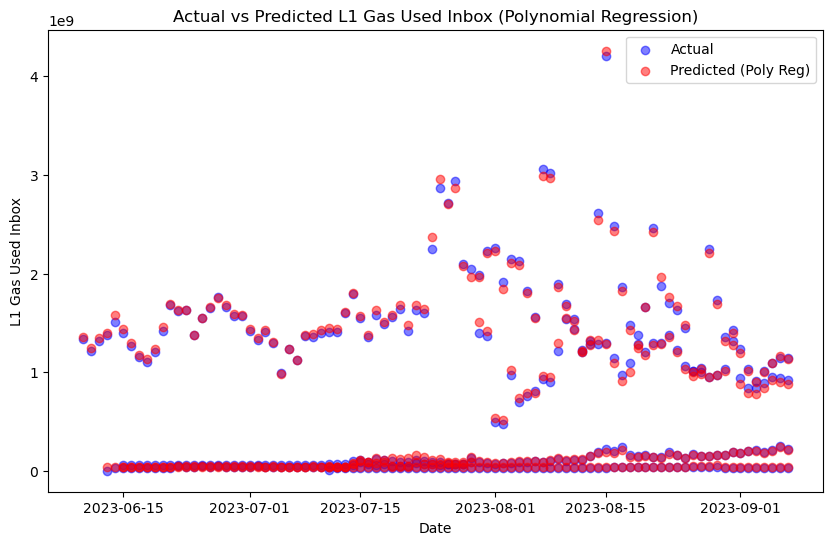

In [ ]:
# Visualizing the actual vs predicted values for the model with polynomial features
plt.figure(figsize=(10, 6))

# Plotting the actual values
plt.scatter(new_data['dt'], new_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')

# Plotting the predicted values from the polynomial regression model
plt.scatter(new_data['dt'], new_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')

# Labeling the axes and setting the title
plt.xlabel('Date')
plt.ylabel('L1 Gas Used Inbox')
plt.title('Actual vs Predicted L1 Gas Used Inbox (Polynomial Regression)')

# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()


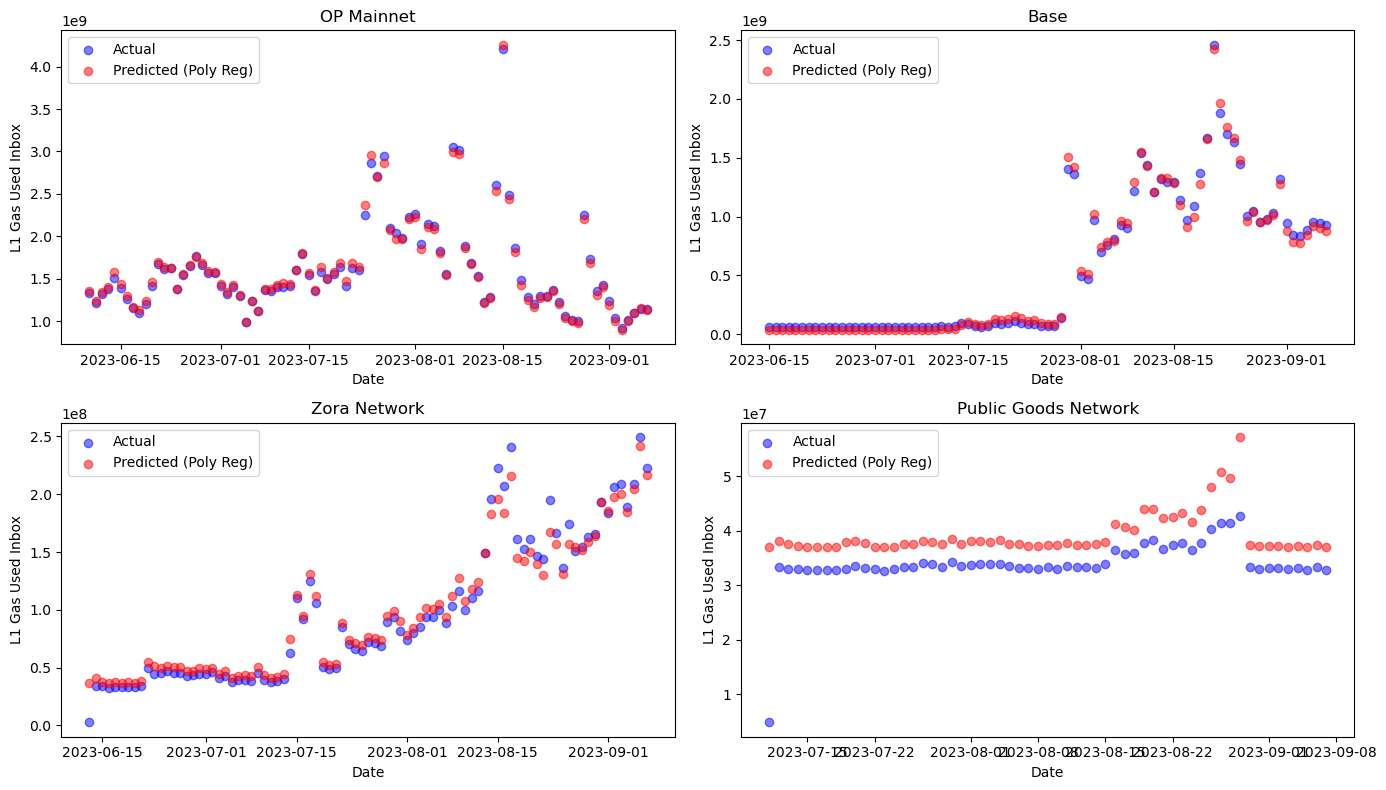

In [ ]:
# Setting up the plot
plt.figure(figsize=(14, 8))

# List of unique chains
chains = new_data['chain'].unique()

# Plotting the actual and predicted values for each chain in separate subplots
for i, chain in enumerate(chains, 1):
    plt.subplot(2, 2, i)
    
    # Filtering the data for the current chain
    chain_data = new_data[new_data['chain'] == chain]
    
    # Plotting the actual values
    plt.scatter(chain_data['dt'], chain_data['l1_gas_used_inbox'], label='Actual', alpha=0.5, color='blue')
    
    # Plotting the predicted values from the polynomial regression model
    plt.scatter(chain_data['dt'], chain_data['predicted_l1_gas_used_inbox_poly'], label='Predicted (Poly Reg)', alpha=0.5, color='red')
    
    # Setting the title to the current chain
    plt.title(chain)
    
    # Labeling the axes
    plt.xlabel('Date')
    plt.ylabel('L1 Gas Used Inbox')
    
    # Displaying the legend
    plt.legend()

# Adjusting the layout to prevent overlapping
plt.tight_layout()

# Displaying the plot
plt.show()
